In [16]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, draw_density_ratio_GP, refine_sample_GP, refine_sample2_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
dataset = ToyGraspDataset(root='data', size=1200)
data = dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks
handle_masks = data[:,3] == 1

In [18]:
# load pos vs neg classifier
f = ClassifierNN([2, 64, 64, 1])
f, info = load_model_info('pos_vs_neg', f)
f = f.to(device)

0.0 0.99972206


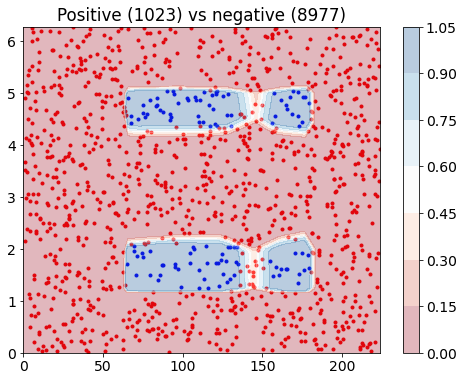

In [19]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)

ax.set_title(f'Positive ({int(info["pos_samples_size"])}) vs negative ({int(info["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

-8.188068 246.96236


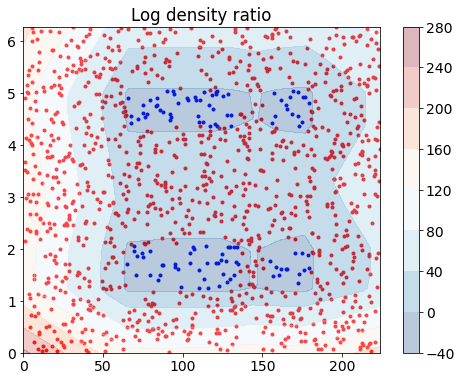

In [20]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05)

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [21]:
# refine samples
my_sample = torch.FloatTensor([[25, 0.3],
                               [210, 3]])#[160, 3]
my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

In [22]:
steps_refinement = 100
all_x1, all_v1 = refine_sample(my_sample.to(device), f, steps=steps_refinement,
                               eta=0.00001, noise_factor=0.001,
                              Nq = info['pos_samples_size'], Np = info['neg_samples_size'])

  0%|          | 0/100 [00:00<?, ?it/s]

-0.933095 28.143309


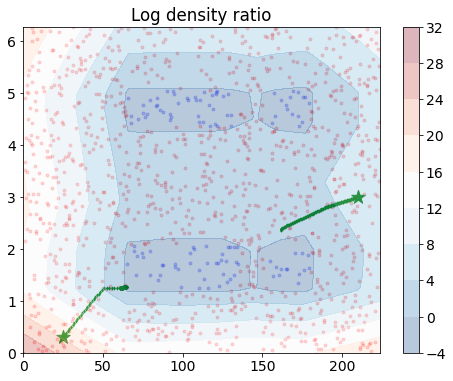

In [23]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)

Z, CS = draw_density_ratio(ax=ax,
                   model=f,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                      Np=info['neg_samples_size'], Nq=info['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Real+ vs Sim+

In [24]:
dataset = ToyGraspDataset(root='data', name='sim2real_train', size=500, is_pos_label=True, device=device)
corr_data = dataset.data
c_pos_masks = corr_data[:,2] == 1
c_neg_masks = ~c_pos_masks


sim2real!!!


In [25]:
# load sim+ vs sim- classifier
f2 = ClassifierNN([2, 32, 32, 1])
f2, info2 = load_model_info('sim_vs_real_1k', f2)
f2 = f2.to(device)

0.0 1.0


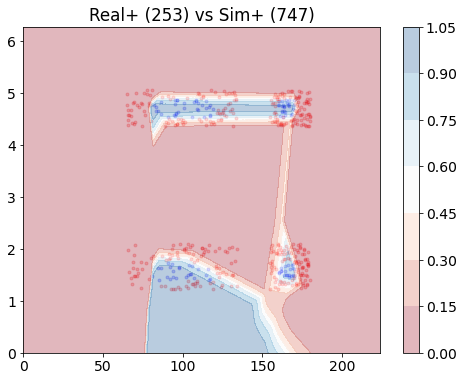

In [26]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')
Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05)




ax.set_title(f'Real+ ({int(info2["pos_samples_size"])}) vs Sim+ ({int(info2["neg_samples_size"])})')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [27]:
steps_refinement = 100
all_x1, all_v1 = refine_sample(my_sample.to(device), f2, steps=steps_refinement,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = info2['pos_samples_size'], Np = info2['neg_samples_size'])

  0%|          | 0/100 [00:00<?, ?it/s]

-5.9434032 42.41794


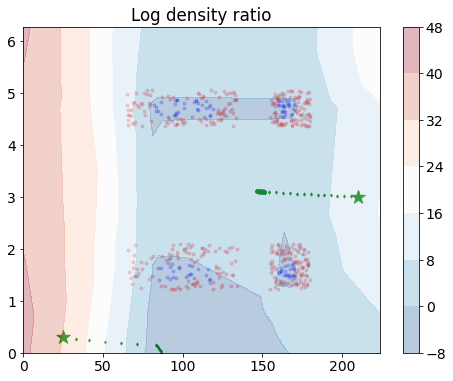

In [28]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)


Z, CS = draw_density_ratio(ax=ax,
                   model=f2,
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np=info2['neg_samples_size'], Nq=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Multiple classifiers

In [29]:
steps_refinement = 50
all_x8, all_v8 = refine_sample2(my_sample.to(device), f, f2,
                                steps=steps_refinement,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
all_x8 = torch.cat(all_x8).numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
# Np1=info['neg_samples_size'],
#                                 Nq1=info['pos_samples_size'],
#                                 Np2=info2['neg_samples_size'],
#                                 Nq2=info2['pos_samples_size']

-11.04302 81487.73


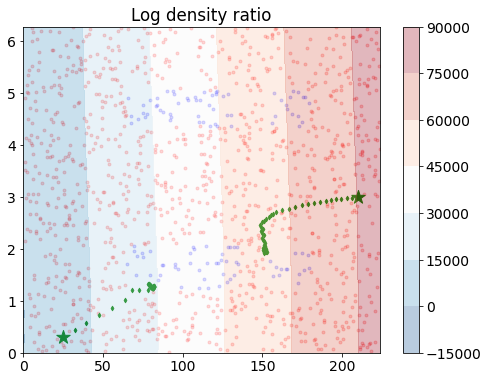

In [31]:
fig, ax = plt.subplots(nrows=1, figsize=(8,6))
ax.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# for i in range(1, steps_refinement, 1):
plt.scatter(all_x8[:,0]*224, all_x8[:,1]*(2*3.14), marker='d', color='g', s=10)

Z, CS = draw_density_ratio2(ax=ax,
                   model1=f,
                   model2=f2,
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu_r',
                   step_size=0.05,
                   Np1=info['neg_samples_size'],
                   Nq1=info['pos_samples_size'],
                   Np2=info2['neg_samples_size'],
                   Nq2=info2['pos_samples_size'])

ax.set_title(f'Log density ratio')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

# GP Classifier Sim+ vs Real+

In [32]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP, draw_density_ratio_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)


sim2real!!!


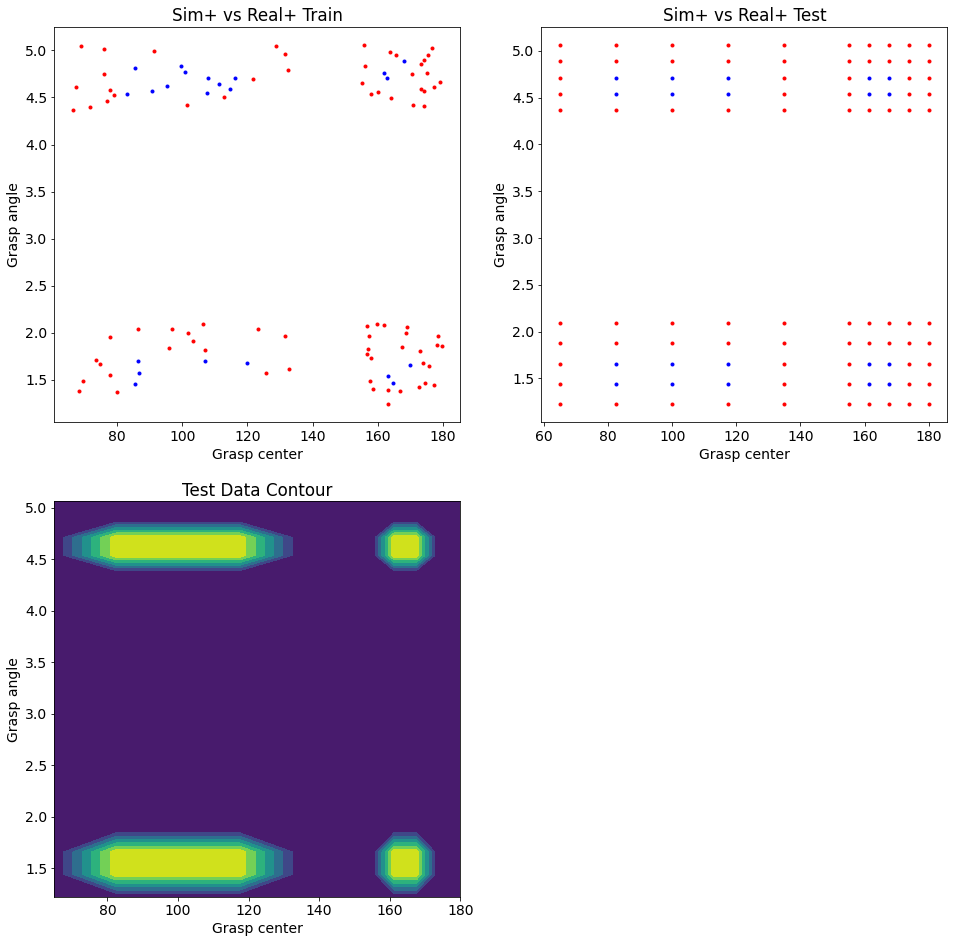

In [33]:
# USING 2D FORK DATA ===============================

n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=100, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)



# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long()
x_t = train_x.clone()
# Normalize inputs
x_t[:,0] /= 244
x_t[:,1] /= (3.14*2)

y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
# test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_y = torch.Tensor(test_dataset.data[:,2]).long()
test_labels = torch.reshape(test_y, (n, n))





fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(221)

# show the data
data = train_dataset.data
pos_masks = data[:,2] == 1
neg_masks = ~pos_masks

ax1.scatter(data[pos_masks][:,0], data[pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(data[neg_masks][:,0], data[neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Sim+ vs Real+ Train')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')





ax2 = fig.add_subplot(222)
test_pos_masks = test_y == 1
test_neg_masks = ~test_pos_masks

ax2.scatter(test_x[test_pos_masks][:,0], test_x[test_pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax2.scatter(test_x[test_neg_masks][:,0], test_x[test_neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax2.set_title('Sim+ vs Real+ Test')
ax2.set_xlabel('Grasp center')
ax2.set_ylabel('Grasp angle')





ax3 = fig.add_subplot(223)
ax3.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax3.set_title('Test Data Contour')
ax3.set_xlabel('Grasp center')
ax3.set_ylabel('Grasp angle')






plt.show()

In [34]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel



# We will use the simplest form of GP model, exact inference
class ExactGPModel(ExactGP):
#     def __init__(self, train_x, train_y, likelihood, num_classes):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_t, train_y, likelihood)

# class DirichletGPModel(ExactGP):
#     def __init__(self, train_x, train_y, likelihood, num_classes):
#         super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
#         self.covar_module = ScaleKernel(
#             RBFKernel(batch_shape=torch.Size((num_classes,))),
#             batch_shape=torch.Size((num_classes,)),
#         )
        
#         self.mean_module = gpytorch.means.ConstantMean()
#         self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())


#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
# likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=False) 
# model = DirichletGPModel(x_t, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)


# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = likelihood(model(x_t))
#     print(output.loc[:10])
    
    # Calc loss and backprop gradients
#     loss = -mll(output, likelihood.transformed_targets).sum()
    loss = -mll(output, train_y).sum()
#     loss = -mll(output, ytrain_tensor)

    loss.backward()

#     train_accuracy = (torch.round(output.loc.clone()) == train_y).sum().item()
    
    if i % 10 == 0:

        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))        
#         print('Iter %d/%d - Loss: %.3f - Acc: %.3f' % (i + 1, training_iter, loss.item(), train_accuracy))
#         print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/100 - Loss: 1.177   lengthscale: 0.693   noise: 0.693
Iter 11/100 - Loss: 0.846   lengthscale: 1.285   noise: 0.313
Iter 21/100 - Loss: 0.595   lengthscale: 1.845   noise: 0.131
Iter 31/100 - Loss: 0.565   lengthscale: 2.040   noise: 0.069
Iter 41/100 - Loss: 0.560   lengthscale: 1.762   noise: 0.071
Iter 51/100 - Loss: 0.549   lengthscale: 1.324   noise: 0.091
Iter 61/100 - Loss: 0.547   lengthscale: 0.935   noise: 0.092
Iter 71/100 - Loss: 0.541   lengthscale: 0.553   noise: 0.084
Iter 81/100 - Loss: 0.529   lengthscale: 0.192   noise: 0.082
Iter 91/100 - Loss: 0.502   lengthscale: 0.042   noise: 0.078


In [35]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [210, 3]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)


model.to(device)
model.eval()
likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

22 78
22 78


  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
# train_x
# all_x1

  0%|          | 0/10 [00:00<?, ?it/s]

0.4863374 0.72288597


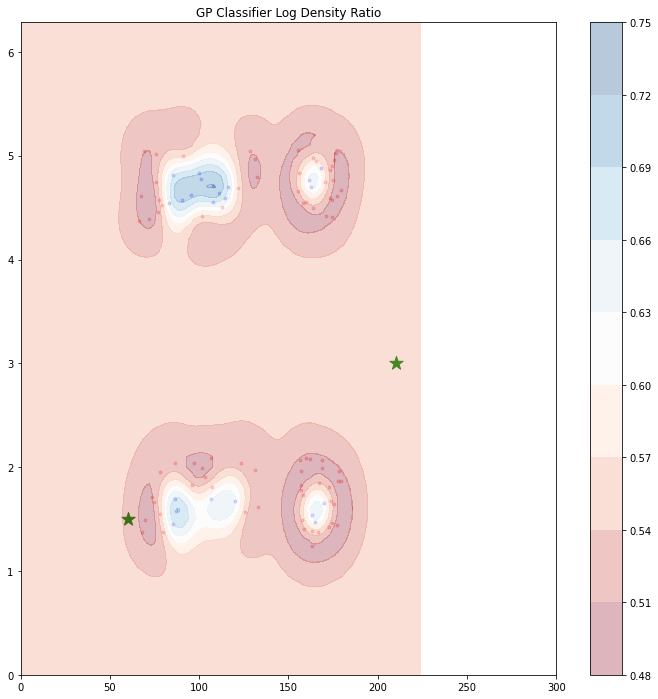

In [37]:
import torch
torch.cuda.empty_cache()
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0], train_x[pos_masks][:,1], marker='.', alpha=0.2, color='b')
ax.scatter(train_x[neg_masks][:,0], train_x[neg_masks][:,1], marker='.', alpha=0.2, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)


Z, CS = draw_density_ratio_GP(ax=ax,
                   model=model,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()

# Refining Multiple Grasps

1. Create test dataset
2. Refine datapoints
    - using single refinement
    - using corrector refinement
3. create graph/table

real_refine!!


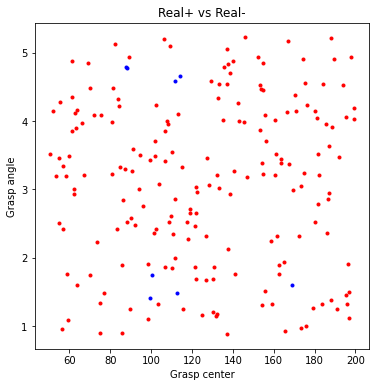

In [38]:
from dataset import ToyGraspDataset
# real_dataset = ToyGraspDataset(root='data', size=10000, is_pos_label=True, device=device)
real_dataset = ToyGraspDataset(root='data', name='real_refine', size=200, is_pos_label=True, device=device)

# show the data
real_data = real_dataset.data
real_pos_masks = real_data[:,2] == 1
real_neg_masks = ~real_pos_masks


fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)

ax1.scatter(real_data[real_pos_masks][:,0], real_data[real_pos_masks][:,1], marker='.', alpha=1.0, color='b')
ax1.scatter(real_data[real_neg_masks][:,0], real_data[real_neg_masks][:,1], marker='.', alpha=1.0, color='r')
ax1.set_title('Real+ vs Real-')
ax1.set_xlabel('Grasp center')
ax1.set_ylabel('Grasp angle')

plt.show()

real_data = torch.tensor(real_data[:,:2])
real_data[:,0] /= 224
real_data[:,1] /= (2*3.14)

all_data = {}

In [39]:
# load pos vs neg classifier
f1 = ClassifierNN([2, 64, 64, 1])
f1, info1 = load_model_info('pos_vs_neg', f1)
f1 = f1.to(device)
all_data['f1'] = f1
all_data['info1'] = info1

In [40]:
# load sim+ vs sim- classifier
f2 = ClassifierNN([2, 32, 32, 1])
f2, info2 = load_model_info('sim_vs_real_1k', f2)
# f2, info2 = load_model_info('sim_vs_real_2.5k', f2)
# f2, info2 = load_model_info('sim_vs_real_1k', f2)
f2 = f2.to(device)
all_data['f2'] = f2
all_data['info2'] = info2

In [41]:
f4 = model
info4={}
info4['pos_samples_size'] = Nq
info4['neg_samples_size'] = Np
all_data['f4'] = f4
all_data['info4'] = info4

In [42]:
# set refinement parameters
f_div = 'KL'
steps_refinement = 100

## Classifier Refinement

In [43]:
all_x1, all_v1 = refine_sample(real_data.to(device), f1, steps=steps_refinement, f=f_div,
                               eta=0.00001, noise_factor=0.001,
                              Nq = info1['pos_samples_size'], Np = info1['neg_samples_size'])

refined_points = all_x1[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_orig_pos = np.sum(real_pos_masks)
n_refined_pos, pos_mask = count_real_positives(refined_points)

all_data['all_x1'] = all_x1
all_data['all_v1'] = all_v1
all_data['n_orig_pos'] = n_orig_pos
all_data['n_pos_1'] = n_refined_pos
all_data['pos_mask_1'] = pos_mask


print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

8
40


## NN Corrector Refinement 

In [44]:
all_x2, all_v2 = refine_sample(real_data.to(device), f2, steps=steps_refinement, f=f_div,
                               eta=0.0001, noise_factor=0.0000,
                              Nq = info2['pos_samples_size'], Np = info2['neg_samples_size'])
refined_points = all_x2[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_2'] = pos_mask

all_data['all_x2'] = all_x2
all_data['all_v2'] = all_v2
all_data['n_pos_2'] = n_refined_pos

print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

8
39


## Classifier + NN Corrector Refinement

In [45]:
all_x3, all_v3 = refine_sample2(real_data.to(device), f1, f2,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info2['neg_samples_size'],
                                Nq2=info2['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x3[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_3'] = pos_mask
all_data['all_x3'] = all_x3
all_data['all_v3'] = all_v3
all_data['n_pos_3'] = n_refined_pos

print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

8
25


## GP Corrector Refinement

In [46]:
all_x_GC, all_v_GC = refine_sample_GP(real_data.to(device), f4, likelihood,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np=info3['neg_samples_size'],
                                Nq=info3['pos_samples_size'],
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x_GC[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_4'] = pos_mask
all_data['likelihood'] = likelihood
all_data['all_x4'] = all_x_GP
all_data['all_v4'] = all_v_GP
all_data['n_pos_4'] = n_refined_pos

print(n_orig_pos)
print(n_refined_pos)

NameError: name 'info3' is not defined

## Classifier + GP Corrector Refinement

In [304]:
f4 = model
info4={}
info4['pos_samples_size'] = Nq
info4['neg_samples_size'] = Np
all_x_GP, all_v_GP = refine_sample2_GP(real_data.to(device), f1, f4, likelihood,
                                steps=steps_refinement,
#                                 steps=150,
                                f=f_div,
                                eta=0.00004,
                                noise_factor=0.000,
                                Np1=info['neg_samples_size'],
                                Nq1=info['pos_samples_size'],
                                Np2=info3['neg_samples_size'],
                                Nq2=info3['pos_samples_size']
                                )
# all_x8 = torch.cat(all_x8).numpy()

refined_points = all_x_GP[-1].clone()
refined_points[:,0] *= 224
refined_points[:,1] *= (2*3.14)*(180/np.pi)

n_refined_pos, pos_mask = count_real_positives(refined_points)
all_data['pos_mask_5'] = pos_mask

all_data['all_x5'] = all_x_GP
all_data['all_v5'] = all_v_GP
all_data['n_pos_5'] = n_refined_pos


print(n_orig_pos)
print(n_refined_pos)

  0%|          | 0/100 [00:00<?, ?it/s]

5
45


In [305]:
all_data.keys()

dict_keys(['f1', 'info1', 'f2', 'info2', 'f4', 'info4', 'all_x1', 'all_v1', 'n_orig_pos', 'n_pos_1', 'pos_mask_1', 'pos_mask_2', 'all_x2', 'all_v2', 'n_pos_2', 'pos_mask_3', 'all_x3', 'all_v3', 'n_pos_3', 'pos_mask_4', 'likelihood', 'all_x4', 'all_v4', 'n_pos_4', 'pos_mask_5', 'all_x5', 'all_v5', 'n_pos_5'])

In [ ]:
colors = ['b','g','r','c','m','y','k','w']
titles = ['',
          'NN',
          'NN Corrector',
          'NN + NN Corrector',
          'GP Corrector',
          'NN + GP Corrector'
         ]

fig = plt.figure(figsize=(10,50))

for a in range(1,6):
    ax = fig.add_subplot(int(f'51{a}'))

    fig.colorbar(CS, ax=ax)
    ax.set_xlim([0, 224])
    ax.set_ylim([0, 2*np.pi])
                         
    pos_mask = all_data[f'pos_mask_{a}']
#     neg_mask = ~pos_mask
                         
    for i in range(50):
#     for i in range(real_data.size(0)):

#     if a!=5:
#         if pos_mask[i]==True:
#             ax.scatter(all_data[f'all_x{a}'][-1][i, 0]*224, all_data[f'all_x{a}'][-1][i,1]*(2*3.14), marker='o', color='b', s=10)
#         else:
#             ax.scatter(all_data[f'all_x{a}'][-1][i, 0]*224, all_data[f'all_x{a}'][-1][i,1]*(2*3.14), marker='o', color='r', s=10)
#     else:
        for j in range(1, steps_refinement, 5):
            if pos_mask[i]==True:
                ax.scatter(all_data[f'all_x{a}'][j][i, 0]*224, all_data[f'all_x{a}'][j][i,1]*(2*3.14), marker='o', color='b', s=10)
            else:
                ax.scatter(all_data[f'all_x{a}'][j][i, 0]*224, all_data[f'all_x{a}'][j][i,1]*(2*3.14), marker='o', color='r', s=10)

#     info = None
    
    if a<3:
        f = all_data[f'f{a}']
        info = all_data[f'info{a}']
    elif a == 3:
        f = all_data['f2']
        info = all_data['info2']
    elif a>=4:
        f = all_data['f4']
        info = all_data['info4']             
                         
    if a < 4:
        Z, CS = draw_density_ratio(ax=ax,
                           model=f,
        #                    p_type='log_density_ratio',
                           p_type='p_y_given_x',
                           device=device,
                           x_lim=[0, 224],
                           y_lim=[0, 2*np.pi],
                           cmap='RdBu',
                           step_size=0.05,
                           Np=info['neg_samples_size'], Nq=info['pos_samples_size'])
    else:

        Z, CS = draw_density_ratio_GP(ax=ax,
                           model=f,
                           likelihood=all_data['likelihood'],
                           p_type='p_y_given_x',
        #                    p_type='log_density_ratio',
                           device=device,
                           x_lim=[0, 224],
                           y_lim=[0, 2*np.pi],
                           cmap='RdBu',
                           step_size=0.1,
                           Np=info['neg_samples_size'],
                           Nq=info['pos_samples_size'])
    # Z, CS = draw_density_ratio2(ax=ax,
    #                    model1=f,
    #                    model2=f2,
    #                    device=device,
    #                    x_lim=[0, 224],
    #                    y_lim=[0, 2*np.pi],
    #                    cmap='RdBu',
    #                    step_size=0.05,
    #                    Np1=info['neg_samples_size'],
    #                    Nq1=info['pos_samples_size'],
    #                    Np2=info2['neg_samples_size'],
    #                    Nq2=info2['pos_samples_size'])
    ax.set_title(f"{titles[a]} {all_data[f'n_pos_{a}']}/{real_data.size(0)}", fontsize=20)
    


plt.show()

0.0 0.99972206
0.0 1.0
0.0 1.0


  0%|          | 0/10 [00:00<?, ?it/s]

0.4533177 0.7647675


  0%|          | 0/10 [00:00<?, ?it/s]

0.4533177 0.7647675


In [311]:
info['pos_samples_size']

25

  0%|          | 0/10 [00:00<?, ?it/s]

0.4379189 0.7835915


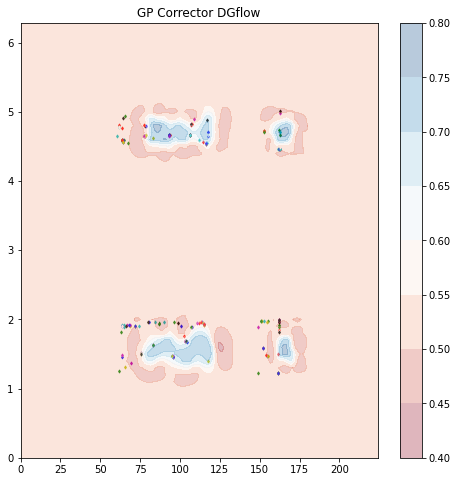

In [155]:
colors = ['b','g','r','c','m','y','k','w']

fig, ax = plt.subplots(nrows=1, figsize=(8,8))
# ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')


# for i in range(real_data.size(0)):
# for i in range(10):
#     plt.scatter(real_data[i, 0]*224, real_data[i,1]*(2*3.14), marker='*', color=colors[i%8], s=200)
#     for j in range(1, steps_refinement, 1):
#         plt.scatter(all_x_GP[j][i, 0]*224, all_x_GP[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)



for i in range(real_data.size(0)):
# for i in range(10):
#     plt.scatter(real_data[i, 0]*224, real_data[i,1]*(2*3.14), marker='*', color=colors[i%8], s=200)
    plt.scatter(all_x_GP[-1][i, 0]*224, all_x_GP[-1][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)



Z, CS = draw_density_ratio_GP(ax=ax,
                   model=f3,
                   likelihood=likelihood,
                   p_type='p_y_given_x',
#                    p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=info3['neg_samples_size'],
                   Nq=info3['pos_samples_size'])


# ax.set_title(f'Log density ratio')
ax.set_title(f'GP Corrector DGflow')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

  0%|          | 0/38 [00:00<?, ?it/s]

0.047167063 0.9845776


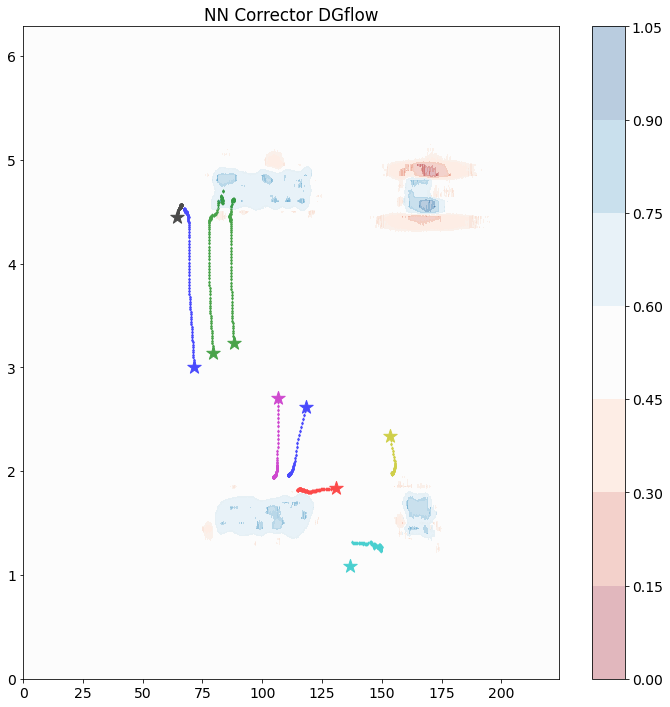

In [151]:
colors = ['b','g','r','c','m','y','k','w']

fig, ax = plt.subplots(nrows=1, figsize=(12,12))
# ax.scatter(corr_data[c_pos_masks][:,0], corr_data[c_pos_masks][:,1], marker='.', alpha=0.2, color='b')
# ax.scatter(corr_data[c_neg_masks][:,0], corr_data[c_neg_masks][:,1], marker='.', alpha=0.2, color='r')


# for i in range(real_data.size(0)):
for i in range(10):
    plt.scatter(real_data[i, 0]*224, real_data[i,1]*(2*3.14), marker='*', color=colors[i%8], s=200)
    for j in range(1, steps_refinement, 1):
        plt.scatter(all_x8[j][i, 0]*224, all_x8[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)
#         plt.scatter(all_xr[j][i, 0]*224, all_xr[j][i,1]*(2*3.14), marker='d', color=colors[i%8], s=4)






Z, CS = draw_density_ratio_GP(ax=ax,
#                    model=f,
                   model=f3,
                   likelihood=likelihood,
#                    p_type='log_density_ratio',
                   p_type='p_y_given_x',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.05,
                   Np=info3['neg_samples_size'], Nq=info3['pos_samples_size'])

# Z, CS = draw_density_ratio2(ax=ax,
#                    model1=f,
#                    model2=f2,
#                    device=device,
#                    x_lim=[0, 224],
#                    y_lim=[0, 2*np.pi],
#                    cmap='RdBu',
#                    step_size=0.05,
#                    Np1=info['neg_samples_size'],
#                    Nq1=info['pos_samples_size'],
#                    Np2=info2['neg_samples_size'],
#                    Nq2=info2['pos_samples_size'])



# ax.set_title(f'Log density ratio')
ax.set_title(f'NN Corrector DGflow')
fig.colorbar(CS, ax=ax)
ax.set_xlim([0, 224])
ax.set_ylim([0, 2*np.pi])

plt.show()

In [16]:
item = load_item('fork')

In [17]:
# from matplotlib.patches import ArrowStyle
from matplotlib import animation
# arrow_style = ArrowStyle("Simple", head_length=.6, head_width=1.0, tail_width=.1)
from matplotlib.patches import Arrow

In [18]:
%matplotlib notebook

In [19]:
sample_stream = all_x8[1::2]

<IPython.core.display.Javascript object>


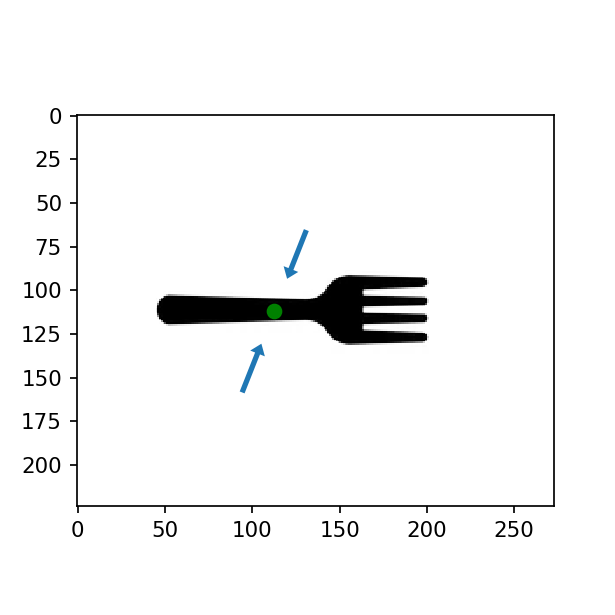

In [20]:
# def animate_grasp(sample_stream, fname):
fname = 'bad_to_pos_handle'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()

In [21]:
sample_stream = all_x8[::2]

<IPython.core.display.Javascript object>


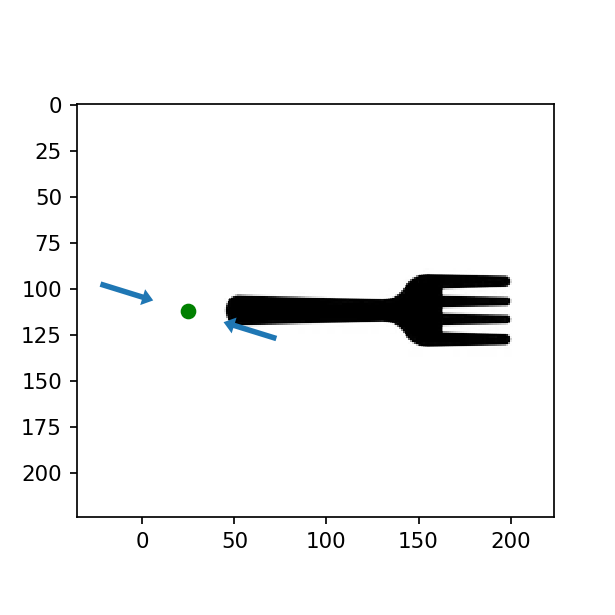

In [22]:
# def animate_grasp(sample_stream, fname):
fname = 'neg_to_pos'
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))
x, angle = sample_stream[0]
x *= 224
angle *= 2*3.14
x2_coef = np.sin(angle)
x1_coef = np.cos(angle)
x1 = x + x1_coef*50#+50#*50
x2 = 224/2 + x2_coef*50# +50#*50

im = ax.imshow(item, cmap='Greys')
arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
arr1 = ax.add_patch(arr1)

x1 = x - x1_coef*50
x2 = 224/2 - x2_coef*50
arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
arr2 = ax.add_patch(arrow)

origin = ax.scatter(x, 224/2, s=40, color='g')


def init():
    global im, arr1, arr2, origin

    x, angle = sample_stream[0]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arr1 = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    ax.add_patch(arr1)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

# let us make animation
def animate(i):
    global im, arr1, arr2, origin
    if i <=30:
        init()
        return
    else:
        i = i - 30
    x, angle = sample_stream[i]
    x *= 224
    angle *= 2*3.14
    x2_coef = np.sin(angle)
    x1_coef = np.cos(angle)
    x1 = x + x1_coef*50#+50#*50
    x2 = 224/2 + x2_coef*50# +50#*50

    arr1.remove()
    arrow = Arrow(x1,x2,x+x1_coef*20-x1, 224/2+x2_coef*20-x2, width=15)
    arr1 = ax.add_patch(arrow)

    arr2.remove()
    x1 = x - x1_coef*50
    x2 = 224/2 - x2_coef*50
    arrow = Arrow(x1,x2, x-x1_coef*20-x1, 224/2-x2_coef*20-x2, width=15)
    arr2 = ax.add_patch(arrow)


    origin.set_offsets((x, 224/2))
    return im, arr1, arr2, origin

Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=20000)

anim = animation.FuncAnimation(fig, animate, init_func=init, interval=1500, blit=True, frames=30+sample_stream.shape[0])
anim.save(f'{fname}.mp4', writer=writer)
plt.show()